# Constraint optimization with reinforcement learning
> This is the first notebook of a series of tutorials to use the [BOUNCE library](https://borjarequena.github.io/BOUNCE/), which we developed for the [Certificates of quantum many-body properties assisted by machine learning](https://arxiv.org/abs/2103.03830) paper.

In this notebook, we show the basic principles to optimize relaxations based on semidefinite programming (SdP) with reinforcement learning. To ease the introduction, we fix an optimization problem that we aim to relax. In this case, we want to approximate the ground state energy of many-body quantum Hamiltonians. More precisely, we aim to find the optimal set of compatibility constraints, under a limited computational budget.

The optimal relaxation provides the best approximation to the system's ground state energy $E_0$ using the least amount of computational resources. In general, there is a tradeoff between such accuracy and the problem complexity: tighter relaxations provide better bounds to the ground state energy at the cost of higher computational requirements. However, some smart relaxations may provide comparable results (or even better!) than others incurring a larger cost, and finding these is the main goal of this work.

# Define the problem

First of all, we need to define our optimization problem. We will start by defining our Heisenberg XX Hamiltonian in a 1-dimensional chain. The XX model in one dimension is $$H=\sum_{i} J_{i}(\sigma_{i}^x \sigma_{i+1}^x + \sigma_{i}^y \sigma_{i+1}^y) + \sum_{i}B_{i}\sigma_{i}^z\,,$$ where $\sigma^\alpha$ denote the Pauli matrices with $\alpha=x,y,z$.

## Hamiltonian

So the first step is to define the Hamiltonian (see the [Hamiltonian docs](https://borjarequena.github.io/BOUNCE/hamiltonian.html)). We need two main ingredients: the topology and the interactions. We define the topology through a `Graph`, which in this case is a one-dimensional chain. 

In the library, we have predefined some typical graphs, including the chain. This makes our life much easier now, as we simply need to choose the size!

In [ ]:
from bounce.hamiltonian import Chain1D

In [ ]:
N = 6
chain = Chain1D(N)

Now that we have the topology, we define the desired interactions of the Hamiltonian over the graph. Just like with the typical graphs, we also have some pre-defined Hamiltonians, including the XX model.

We simply need to specify the linear and quadratic terms, $B_i$ and $J_i$, respectively. This gives us full control over the problem parameters. We can do so by providing a list of values for each individual site, in case that we want to create a very specific Hamiltonian, or we can provide a smaller pattern that will be replicated over the system. Therefore, for a homogeneous Hamiltonian we can simply provide the value $J_i=J, B_i=B \ \forall i$.

To illustrate the functionality, we will take a repeating pattern in the interaction $J_i$ and a constant magnetic field $B$.

In [ ]:
from bounce.hamiltonian import XXHamiltonian

In [ ]:
b, j = 1., [0, 1, 2]
H = XXHamiltonian(chain, b, j)

Now we can visualize our Hamiltonian to ensure that this is the actual system that we wanted.

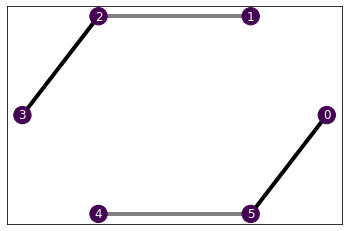

In [ ]:
H.draw()

Nice! We see that all the nodes have the same color (indicating $B_i$) and the connections have different transparency, indicating the value of $J_i$. We can see the details by looking at the interactions.

In [ ]:
H.interactions

[(array([0]), <2×2 Real Constant: z>),
 (array([1]), <2×2 Real Constant: z>),
 (array([2]), <2×2 Real Constant: z>),
 (array([3]), <2×2 Real Constant: z>),
 (array([4]), <2×2 Real Constant: z>),
 (array([5]), <2×2 Real Constant: z>),
 (array([0, 1]), <4×4 Complex Constant: 0>),
 (array([1, 2]), <4×4 Complex Constant: x⊗x + y⊗y>),
 (array([2, 3]), <4×4 Complex Constant: 2·(x⊗x + y⊗y)>),
 (array([3, 4]), <4×4 Complex Constant: 0>),
 (array([4, 5]), <4×4 Complex Constant: x⊗x + y⊗y>),
 (array([0, 5]), <4×4 Complex Constant: 2·(x⊗x + y⊗y)>)]

## Environment

Now that we have the problem, we can define the environment. In reinforcement learning, the environment handles the "rules of the game". In this case, it will host the physical problem that we tackle together with an associated solver to the problem and the maximum computational cost that we want to work with.

For every problem, we need an associated `SdPSolver` (see the [SdP docs](https://borjarequena.github.io/BOUNCE/sdp.html)). The Hamiltonian defines the problem and the solver defines the objective. In this case, we look for the ground state energy, so we will use the `SdPEnergySolver`. 

In [ ]:
from bounce.sdp import SdPEnergySolver

In [ ]:
solver = SdPEnergySolver()

We now define a computational budget in terms of the `solver.ojimetro` method. In this case, the `ojimetro` estimates the computational cost of the problem based on the amount of free parameters. We will provide a maximum of 300 free parameters, which allow us to work with up to half of all the 3-body constraints. 

In [ ]:
budget = 300

And we're ready to define our environment!

In [ ]:
from bounce.environment import SdPEnvironment

In [ ]:
env = SdPEnvironment(H, solver, budget)

# Solve the problem

Now that we have a well-defined problem in our environment, we can proceed to optimize our relaxation. We can choose between serveral kinds of optimizations by appropiately defining an agent (see the [agent docs](https://borjarequena.github.io/BOUNCE/agents.html)) and its corresponding trainer (see the [training](https://borjarequena.github.io/BOUNCE/training.html) docs). 

In this case, we will use reinforcement learning. More precisely, we implement it with double deep Q-learning. Don't panic, it's just a fancy name, we don't really need to know anything about it ;)

## Trainer

Therefore, we will use a `DQNTrainer`, which will train our agent based on a deep Q-network.

In [ ]:
from bounce.training import DQNTrainer

In [ ]:
trainer = DQNTrainer(env)

This may seem quite basic, but we do have full control over the agent's hyperparameters. We can provide the trainer with the base architecture for our model, we can provide pre-trained architectures to build our agents from, we can choose the learning rate, the loss function, etc. We're just keeping it easy :)

Now we simply tell our trainer to start training our agent. We need to specify the number of training episodes, which are the repetitions of the "game", and their length. 

In [ ]:
episodes = 500
episode_length = 6
results = trainer.train(episodes, time_steps=episode_length)

  0%|          | 0/500 [00:00<?, ?it/s]

The training should not take long and we can easily visualize the training results with some auxiliary functions.

In [ ]:
from bounce.utils import plot_trainings

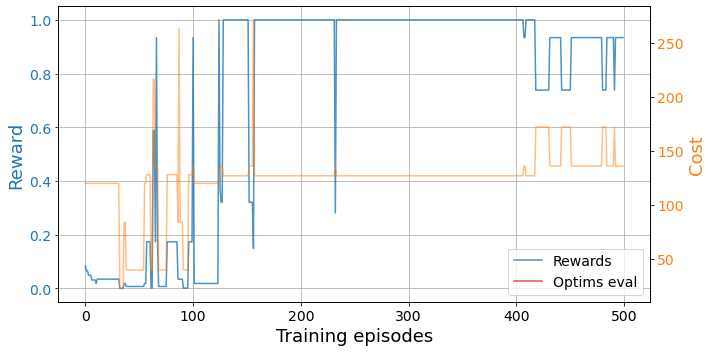

In [ ]:
plot_trainings(results['training'])

The higher the reward, the better (max 1), so we see that our agent managed to find some decent relaxations. We can see which are the best layouts for our problem by looking at the `best_layout` property of the environment. 

In [ ]:
trainer.envs[0].best_layout

[array([1, 2, 3]), array([0, 4, 5])]

Yay, we found something that makes sense! Given our Hamiltonian, the relaxation that provides the best bound with the least amount of parameters is the one that considers the two separate sub-systems. Adding more complexity to this relaxation will not improve the energy bound that we obtain, as the interconnection between the two sub-systems is completely meaningless. 

Notice here that we're indexing over a list of environments. This is because our trainer can handle multiple parallel agent trainings and keeps them in a list with their corresponding list of environments. In this case, we only had a single agent. 

In [ ]:
len(trainer.agents), len(trainer.envs)

(1, 1)

We can also see its energy value and its cost (in terms of the SdP free parameters). The `SdPEnvironment.best` property otputs the best bound together with the best and worst costs it has been found.  

In [ ]:
trainer.envs[0].best_layout

[array([1, 2, 3]), array([0, 4, 5])]

In [ ]:
trainer.envs[0].best

array([-10.94427191, 127.        , 288.        ])

## Parallel training

Usually, when we face an optimization problem from which we do not know the solution, we want to launch several optimizers to maximize our chances of getting lucky. For this purpose, our trainer can handle the parallel training of various agents at once.

Let's train two agents in parallel.

In [ ]:
trainer = DQNTrainer(env, n_agents=2, n_jobs=2)

In [ ]:
results = trainer.train(episodes, time_steps=episode_length)

Now we can look at the best relaxations found by each of them.

In [ ]:
[env.best_layout for env in trainer.envs]

[[array([1, 2, 3]), array([0, 4, 5])], [array([1, 2, 3]), array([0, 4, 5])]]

Ayyy, they both found the optimal relaxation! 